In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import math
import numpy as np

import gc
import GPUtil
import os
from os import walk
import evaluator

evaluator = evaluator.Evaluator()

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class GenNet(nn.Module):
    def __init__(self):
        super(GenNet, self).__init__()
        
        self.block1 = GenNetBlock(4, 8)
        self.block2 = GenNetBlock(16, 16)
        self.block3 = GenNetBlock(24, 24)
        self.block4 = GenNetBlock(32, 32)
        self.block5 = GenNetBlock(40, 40)
        self.block6 = GenNetBlock(48, 48)
        
        self.upscale1 = Upscale(8, 32)
        self.upscale2 = Upscale(16, 64)
        self.upscale3 = Upscale(24, 128)
        self.upscale4 = Upscale(32, 256)
        self.upscale5 = Upscale(40, 512)
        
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(24)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(40)
        
        self.rgb = nn.Conv2d(40, 3, 1, stride=1, padding=0)
    
    def forward(self, content_img):
        i = 0
        z = []
        y = []
        for i in range(5):
            size = (2 ** i) * 16
            z.append(torch.FloatTensor(1,1,size, size).uniform_(0, 0.01).to(device))
            y.append(F.interpolate(content_img, (size,size)).to(device))

        output_zk_0 = self.block1(torch.cat((z[0], y[0]), 1))
        output_zk_1 = self.block1(torch.cat((z[1], y[1]), 1))
        output_zk_2 = self.block1(torch.cat((z[2], y[2]), 1))
        output_zk_3 = self.block1(torch.cat((z[3], y[3]), 1))
        output_zk_4 = self.block1(torch.cat((z[4], y[4]), 1))

        out = self.upscale1(output_zk_0)
        out = torch.cat((self.bn1(out), self.bn1(output_zk_1)), 1)
        
        out = self.block2(out)
        out = self.upscale2(out)
        out = torch.cat((self.bn2(out), self.bn1(output_zk_2)), 1)
        
        out = self.block3(out)
        out = self.upscale3(out)
        out = torch.cat((self.bn3(out), self.bn1(output_zk_3)), 1)
        
        out = self.block4(out)
        out = self.upscale4(out)
        out = torch.cat((self.bn4(out), self.bn1(output_zk_4)), 1)
        
        out = self.block5(out)
        
        out = self.rgb(out)

        return out
    
class GenNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GenNetBlock, self).__init__()
        self.genBlock = nn.Sequential(
            ConvLayer(in_channels, out_channels, 3, 1),
            ConvLayer(out_channels, out_channels, 3, 1),
            ConvLayer(out_channels, out_channels, 1, 1))

    
    def forward(self, x):
        out = self.genBlock(x)
        return out

class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        mirror_padding = int((kernel_size - 1) / 2)
        self.block = nn.Sequential(nn.ReflectionPad2d(mirror_padding),
                                   nn.Conv2d(in_channels, out_channels, kernel_size, stride),
                                   nn.BatchNorm2d(out_channels),
                                   nn.LeakyReLU())

    def forward(self, x): 
        out = self.block(x)
        return out
    
    
class Upscale(torch.nn.Module):
    def __init__(self, channels, size):
        super(Upscale, self).__init__()
        self.upscale = nn.Sequential(nn.Upsample(size=(size,size)))

    def forward(self, x):
        out = self.upscale(x)
        return out
    

In [4]:
torch.cuda.empty_cache()

imsize = 256 if torch.cuda.is_available() else 128


loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),
    transforms.ToTensor()])


mypath = "./images"
_, _, filenames = next(walk(mypath))


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

imgs = []
for i in range(len(filenames)):
    temp = image_loader("./images/" + filenames[i])
    imgs.append(temp)
    
    

In [5]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [6]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        val = 0
        for i in range(self.target.shape[1]):
            val += (torch.norm(self.target[:,i,:,:] - x[:,i,:,:], p=2)).pow(2)
        self.loss = val
        return x

In [7]:
def gram_matrix(y):
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram

In [8]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, x):
        G = gram_matrix(x)
        self.loss = (torch.norm(G - self.target, p=2)).pow(2)
        return x

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [10]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [11]:
# desired depth layers to compute style/content losses :
content_layers_default = ['relu_8']
style_layers_default = ['relu_1', 'relu_3', 'relu_5', 'relu_7', 'relu_10']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [12]:
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

In [13]:
style_img_name = "warhol"

def train(net, cnn, normalization_mean, normalization_std, style_img_name, imgs, num_steps=300, style_weight=1000000, content_weight=1):
    
    best_score = 1e5
    cur_score = 0
    cur_lr = 0.1
    
    optimizer = optim.Adam(net.parameters(), lr=cur_lr)
    
    style_img_path = "./style_imgs/{}.jpg".format(style_img_name)
    style_img = image_loader(style_img_path)
    
    plt.figure()
    imshow(style_img, title='Style Image')
    
    print('Optimizing..')
    run = [0]
    while run[0] < num_steps:
            
        
        for i in range(len(imgs)):
            content_img = imgs[i]
            desc_model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                      normalization_mean,
                                                                      normalization_std,
                                                                      style_img, 
                                                                      content_img)
            
            if ((run[0]+100) % 200 == 0 and run[0] >= 500):
                for param_group in optimizer.param_groups:
                    cur_lr = cur_lr*0.7
                    param_group['lr'] = cur_lr
                    print("current lr:" + str(cur_lr))
                    
            def closure():
                content_img.data.clamp_(0, 1)
                optimizer.zero_grad()

                output = net(content_img)

                gc.collect()
                torch.cuda.empty_cache()

                desc_model(output)

                style_score = 0
                content_score = 0
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                style_score *= style_weight
                content_score *= content_weight

                loss = style_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:.4e} Content Loss: {:.4e}'.format(
                        style_score.item(), content_score.item()))
                    print()
                
                cur_score = style_score.item()

                return style_score + content_score

            optimizer.step(closure)
    
    CKPT_PATH = "./saved_model/"
    if not os.path.exists(CKPT_PATH):
            os.makedirs(CKPT_PATH)
    state = {'net': net.state_dict()}
    torch.save(state, os.path.join(CKPT_PATH, '{}.h5'.format(style_img_name)))
            
            

In [14]:
net = GenNet()
net = net.to(device)

In [15]:
train(net, cnn, normalization_mean, normalization_std, style_img_name, imgs, num_steps=800, style_weight=1000, content_weight=0.005)

Successfully loaded checkpoint: ./saved_model/starry_night.h5


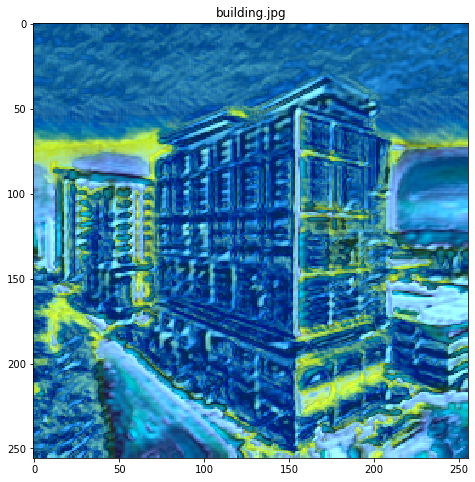

Content Fidelity: 0.5710433125495911
./temp.jpg
./starry_night.jpg
Global Effects: 0.509161114692688
Local Patterns: 0.6125012079874674


<Figure size 432x288 with 0 Axes>

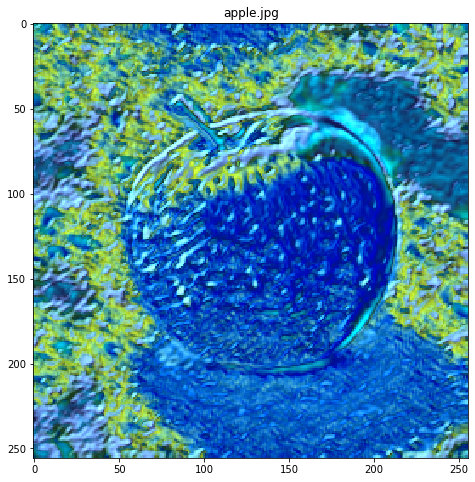

Content Fidelity: 0.3818056881427765
./temp.jpg
./starry_night.jpg
Global Effects: 0.49740034341812134
Local Patterns: 0.6115321477254232


<Figure size 432x288 with 0 Axes>

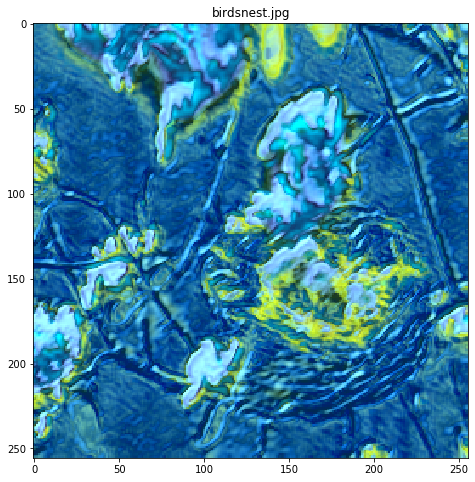

Content Fidelity: 0.5370155572891235
./temp.jpg
./starry_night.jpg
Global Effects: 0.5071220397949219
Local Patterns: 0.613278349240621


<Figure size 432x288 with 0 Axes>

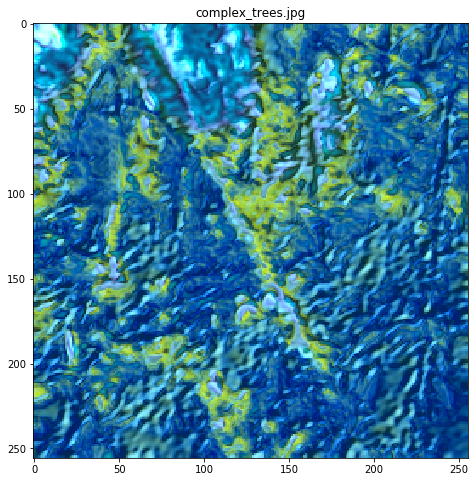

Content Fidelity: 0.5657075643539429
./temp.jpg
./starry_night.jpg
Global Effects: 0.49428725242614746
Local Patterns: 0.6125673294067383


<Figure size 432x288 with 0 Axes>

In [21]:
style_img_name = "starry_night"

checkpoint_path = "./saved_model/{}.h5".format(style_img_name)
ckpt = get_checkpoint(checkpoint_path)
if ckpt is not None:
    print("Successfully loaded checkpoint: %s" %checkpoint_path)
    net.load_state_dict(ckpt['net'])

mypath = "./input_imgs/"
_, _, filenames = next(walk(mypath))

style_img = image_loader("./style_imgs/{}.jpg".format(style_img_name))

num = len(filenames)
for i in range(num):
    input_img = image_loader(mypath + filenames[i])
    output = net(input_img).data.clamp_(0,1)
    
    stylized_content_image_name = "./temp.jpg"
    plt.figure(figsize=(8, 8))
    imshow(output, title=filenames[i])
    plt.ioff()
    plt.savefig(stylized_content_image_name)
    
    desc_model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                      normalization_mean,
                                                                      normalization_std,
                                                                      style_img, 
                                                                      input_img)
    
    cf = evaluator.calculate_content_fidelity(input_img, output, cnn)
    print('Content Fidelity: {}'.format(cf.item()))

    global_effects = evaluator.calculate_global_effects(output, style_img, desc_model, stylized_content_image_name, "./starry_night.jpg")
    print('Global Effects: {}'.format(global_effects.item())) 

    gc.collect()
    torch.cuda.empty_cache()

    lp = evaluator.calculate_local_patterns(output, style_img, desc_model)
    print('Local Patterns: {}'.format(lp))
    
plt.show()